### Example of LSTM and GRU - IMDB dataset

Loading and pre-processing dataset

In [180]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#dataset = pd.read_csv('/kaggle/input/primeira-liga-final/merged_treinofinal.csv')
dataset = pd.read_csv('/kaggle/input/treinofinal/merged_treinofinaltudo.csv')


dataset['dif'] = dataset['goals_home'] - dataset['goals_away']
dataset.loc[dataset['dif'] > 0, 'result'] = '0'
dataset.loc[dataset['dif'] == 0, 'result'] = '1'
dataset.loc[dataset['dif'] < 0, 'result'] = '2'
dataset.loc[dataset['result'] == '0', 'home_Points'] = 3
dataset.loc[dataset['result'] == '1', 'home_Points'] = 1
dataset.loc[dataset['result'] == '2', 'home_Points'] = 0
dataset.loc[dataset['result'] == '2', 'away_Points'] = 3
dataset.loc[dataset['result'] == '1', 'away_Points'] = 1
dataset.loc[dataset['result'] == '0', 'away_Points'] = 0



In [182]:
#Baseline
baseline = dataset.copy()
baseline = baseline[baseline['season'] != 2023]
baseline['B365H'] = baseline['B365H'].astype(float)
baseline['B365A'] = baseline['B365A'].astype(float)
baseline['fav'] = np.where(baseline['B365H'] < baseline['B365A'], 0, 2)
baseline['fav'] = baseline['fav'].astype(int)
baseline['result'] = baseline['result'].astype(int)
baseline['fav_ganhou'] = baseline['fav'] == baseline['result']
baseline['fav_ganhou'].mean()

0.5416666666666666

In [183]:
def movingAveragesFoulsCards(team):
    dfHomeGames = dataset[dataset['home'] == team]
    dfAwayGames = dataset[dataset['away'] == team]
    dfTotal = pd.concat([dfHomeGames,dfAwayGames])

    dfTotal.sort_index(inplace=True)

    dfTotal['Yellows_scored'] = dfTotal.apply(lambda row: row['yellow_card_home'] if row['home'] == team else row['yellow_card_away'],axis=1)
    dfTotal['Yellows_conceeded'] = dfTotal.apply(lambda row: row['yellow_card_away'] if row['home'] == team else row['yellow_card_home'],axis=1)
    dfTotal['Reds_scored'] = dfTotal.apply(lambda row: row['red_card_home'] if row['home'] == team else row['red_card_away'],axis=1)
    dfTotal['Reds_conceeded'] = dfTotal.apply(lambda row: row['red_card_away'] if row['home'] == team else row['red_card_home'],axis=1)
    dfTotal['Yellow_Reds_scored'] = dfTotal.apply(lambda row: row['yellow_red_card_home'] if row['home'] == team else row['yellow_red_card_away'],axis=1)
    dfTotal['Yellow_Reds_conceeded'] = dfTotal.apply(lambda row: row['yellow_red_card_away'] if row['home'] == team else row['yellow_red_card_home'],axis=1)
    dfTotal['Fouls_scored'] = dfTotal.apply(lambda row: row['Faltas_home'] if row['home'] == team else row['Faltas_away'],axis=1)
    dfTotal['Fouls_conceeded'] = dfTotal.apply(lambda row: row['Faltas_away'] if row['home'] == team else row['Faltas_home'],axis=1)
    dfTotal['Goals_scored'] = dfTotal.apply(lambda row: row['goals_home'] if row['home'] == team else row['goals_away'],axis=1)
    dfTotal['Goals_conceeded'] = dfTotal.apply(lambda row: row['goals_away'] if row['home'] == team else row['goals_home'],axis=1)
    dfTotal['Shoots_scored'] = dfTotal.apply(lambda row: row['HS'] if row['home'] == team else row['AS'],axis=1)
    dfTotal['Shoots_conceeded'] = dfTotal.apply(lambda row: row['AS'] if row['home'] == team else row['HS'],axis=1)
    dfTotal['SOT_scored'] = dfTotal.apply(lambda row: row['HST'] if row['home'] == team else row['AST'],axis=1)
    dfTotal['SOT_conceeded'] = dfTotal.apply(lambda row: row['AST'] if row['home'] == team else row['HST'],axis=1)
    dfTotal['Corners_scored'] = dfTotal.apply(lambda row: row['Escanteios_home'] if row['home'] == team else row['Escanteios_away'],axis=1)
    dfTotal['Corners_conceeded'] = dfTotal.apply(lambda row: row['Escanteios_away'] if row['home'] == team else row['Escanteios_home'],axis=1)
    dfTotal['Cruzamentos_scored'] = dfTotal.apply(lambda row: row['Cruzamentos_home'] if row['home'] == team else row['Cruzamentos_away'],axis=1)
    dfTotal['Cruzamentos_conceeded'] = dfTotal.apply(lambda row: row['Cruzamentos_away'] if row['home'] == team else row['Cruzamentos_home'],axis=1)
    dfTotal['Contatos_scored'] = dfTotal.apply(lambda row: row['Contatos_home'] if row['home'] == team else row['Contatos_away'],axis=1)
    dfTotal['Contatos_conceeded'] = dfTotal.apply(lambda row: row['Contatos_away'] if row['home'] == team else row['Contatos_home'],axis=1)
    dfTotal['Bote defensivo_scored'] = dfTotal.apply(lambda row: row['Bote defensivo_home'] if row['home'] == team else row['Bote defensivo_away'],axis=1)
    dfTotal['Bote defensivo_conceeded'] = dfTotal.apply(lambda row: row['Bote defensivo_away'] if row['home'] == team else row['Bote defensivo_home'],axis=1)
    dfTotal['Cortes_scored'] = dfTotal.apply(lambda row: row['Cortes_home'] if row['home'] == team else row['Cortes_away'],axis=1)
    dfTotal['Cortes_conceeded'] = dfTotal.apply(lambda row: row['Cortes_away'] if row['home'] == team else row['Cortes_home'],axis=1)
    dfTotal['Defesas_scored'] = dfTotal.apply(lambda row: row['Defesas_home'] if row['home'] == team else row['Defesas_away'],axis=1)
    dfTotal['Defesas_conceeded'] = dfTotal.apply(lambda row: row['Defesas_away'] if row['home'] == team else row['Defesas_home'],axis=1)
    dfTotal['Impedimentos_scored'] = dfTotal.apply(lambda row: row['Impedimentos_home'] if row['home'] == team else row['Impedimentos_away'],axis=1)
    dfTotal['Impedimentos_conceeded'] = dfTotal.apply(lambda row: row['Impedimentos_away'] if row['home'] == team else row['Impedimentos_home'],axis=1)
    #dfTotal['Tiro de meta_scored'] = dfTotal.apply(lambda row: row['Tiro de meta_home'] if row['home'] == team else row['Tiro de meta_away'],axis=1)
    #dfTotal['Tiro de meta_conceeded'] = dfTotal.apply(lambda row: row['Tiro de meta_away'] if row['home'] == team else row['Tiro de meta_home'],axis=1)
    dfTotal['Bolas longas_scored'] = dfTotal.apply(lambda row: row['Bolas longas_home'] if row['home'] == team else row['Bolas longas_away'],axis=1)
    dfTotal['Bolas longas_conceeded'] = dfTotal.apply(lambda row: row['Bolas longas_away'] if row['home'] == team else row['Bolas longas_home'],axis=1)
    dfTotal['Points_total'] = dfTotal.apply(lambda row: row['home_Points'] if row['home'] == team else row['away_Points'],axis=1)
    
    dfTotal['titulares'] = dfTotal.apply(lambda row: [row['jogador{}_home'.format(i)] for i in range(1, 12) if not pd.isna(row['jogador{}_home'.format(i)])] if row['home'] == team else [row['jogador{}_away'.format(i)] for i in range(1, 12) if not pd.isna(row['jogador{}_home'.format(i)])], axis=1)
    dfTotal['titulares_shifted'] = dfTotal['titulares'].shift(1)
    #print(dfTotal['titulares_shifted'])
    dfTotal['titulares_shifted'] = dfTotal['titulares_shifted'].apply(lambda x: [] if x is None else x)
    dfTotal['titulares_rep'] = dfTotal.apply(lambda row: len(set(row['titulares']).intersection(row['titulares_shifted'])), axis=1)    
    
    listaColunas = ['Yellows_scored', 'Yellows_conceeded', 'Reds_scored', 'Reds_conceeded', 'Yellow_Reds_scored', 'Yellow_Reds_conceeded',
                'Fouls_scored', 'Fouls_conceeded', 'Goals_scored', 'Goals_conceeded', 'Shoots_scored', 'Shoots_conceeded', 'SOT_scored',
                'SOT_conceeded', 'Corners_scored', 'Corners_conceeded', 'Cruzamentos_scored', 'Cruzamentos_conceeded', 'Contatos_scored',
                'Contatos_conceeded', 'Bote defensivo_scored', 'Bote defensivo_conceeded', 'Cortes_scored', 'Cortes_conceeded',
                'Defesas_scored', 'Defesas_conceeded', 'Impedimentos_scored', 'Impedimentos_conceeded', 'Bolas longas_scored', 'Bolas longas_conceeded', 'Points_total'] #'Tiro de meta_scored', 'Tiro de meta_conceeded'


    rows_to_update_home = dfHomeGames.index
    rows_to_update_away = dfAwayGames.index
    
    dataset.loc[rows_to_update_home, f'num_titulares_home'] = dfTotal.loc[rows_to_update_home, f'titulares_rep']
    dataset.loc[rows_to_update_away, f'num_titulares_away'] = dfTotal.loc[rows_to_update_away, f'titulares_rep']
        

    for coluna in listaColunas:
        dfTotal[f'{coluna}_MA5'] = dfTotal[coluna].rolling(5, closed='left').mean()
        #dfTotal[f'{coluna}_MA17'] = dfTotal[coluna].rolling(17, closed='left').mean()
        #dfTotal[f'{coluna}_MA34'] = dfTotal[coluna].rolling(34, closed='left').mean()

        dataset.loc[rows_to_update_home, f'{coluna}_home_MA5'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA5']
        dataset.loc[rows_to_update_away, f'{coluna}_away_MA5'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA5']
        #dataset.loc[rows_to_update_home, f'{coluna}_home_MA17'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA17']
        #dataset.loc[rows_to_update_away, f'{coluna}_away_MA17'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA17']
        #dataset.loc[rows_to_update_home, f'{coluna}_home_MA34'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA34']
        #dataset.loc[rows_to_update_away, f'{coluna}_away_MA34'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA34']

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for team in dataset['home'].unique():
    movingAveragesFoulsCards(team)


In [184]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_t = dataset.copy()
#one_hot_encoded = pd.get_dummies(df_t['home'], prefix='home')
#one_hot_encoded2 = pd.get_dummies(df_t['away'], prefix='away')
one_hot_encoded3 = pd.get_dummies(df_t['Árbitro'], prefix='arbitro')
one_hot_encoded = pd.get_dummies(df_t['Dia'], prefix='dia_')
one_hot_encoded4 = pd.get_dummies(df_t['formacao_home'], prefix='formacao_home')
one_hot_encoded5 = pd.get_dummies(df_t['formacao_away'], prefix='formacao_away')
df_encoded = pd.concat([df_t, one_hot_encoded, one_hot_encoded3, one_hot_encoded4, one_hot_encoded5], axis=1)

epocas = dataset['season'].unique()

for epoca in epocas:
    df_epoca = df_encoded[df_encoded['season'] == epoca]
    # [(equipa, pontos, GM, GS)]
    clas = []
    for equipa in df_epoca['home'].unique():
        clas.append((equipa,0,0,0))
    
    for index, row in df_epoca.iterrows():
        df_encoded.loc[index, 'posicao_casa'] = clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0])+1
        # Buscar posicao equipa fora
        df_encoded.loc[index, 'posicao_fora'] = clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0])+1
        # Somar pontos à equipa casa
        home_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0]))
        clas.append((home_cenas[0], home_cenas[1] + row['home_Points'], home_cenas[2] + row['goals_home'], home_cenas[3] + row['goals_away']))
        # Somar pontos à equipa fora
        away_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0]))
        clas.append((away_cenas[0], away_cenas[1] + row['away_Points'], away_cenas[2] + row['goals_away'], home_cenas[3] + row['goals_home']))
        # ordenar clas
        clas = sorted(clas, key=lambda x: (x[1], x[2]-x[3], x[2]), reverse=True)
        
jogadores_col = ['jogador1_home', 'jogador2_home', 'jogador3_home', 'jogador4_home', 'jogador5_home', 'jogador6_home', 'jogador7_home', 'jogador8_home', 'jogador9_home', 'jogador10_home', 'jogador11_home', 'jogador12_home', 'jogador13_home', 'jogador14_home', 'jogador15_home', 'jogador16_home', 'jogador17_home', 'jogador1_away', 'jogador2_away', 'jogador3_away', 'jogador4_away', 'jogador5_away', 'jogador6_away', 'jogador7_away', 'jogador8_away', 'jogador9_away', 'jogador10_away', 'jogador11_away', 'jogador12_away', 'jogador13_away', 'jogador14_away', 'jogador15_away', 'jogador16_away', 'jogador17_away', 'jogador18_home', 'jogador18_away', 'jogador19_away', 'jogador19_home', 'jogador20_away', 'jogador20_home']

df_encoded.drop(jogadores_col, axis=1, inplace=True)
home_teams = df_encoded['home']
away_teams = df_encoded['away']
df_encoded.drop(['Dia','Horário','goals_home', 'goals_away', 'xG_home', 'xG_away', 'home_Points', 'away_Points','HS', 'AS', 'HST', 'AST', 'HTHG', 'HTAG','Árbitro','formacao_home', 'formacao_away', 'Relatório da Partida', 'Local', 'Faltas_home', 'Faltas_away', 'Escanteios_home', 'Escanteios_away', 'Cruzamentos_home', 'Cruzamentos_away', 'Contatos_home', 'Contatos_away', 'Bote defensivo_home', 'Bote defensivo_away', 'Cortes_home', 'Cortes_away', 'Defesas_home', 'Defesas_away', 'Impedimentos_home', 'Impedimentos_away', 'Tiro de meta_home', 'Tiro de meta_away', 'Bolas longas_home', 'Bolas longas_away', 'yellow_card_home', 'red_card_home', 'yellow_red_card_home', 'yellow_card_away', 'red_card_away', 'yellow_red_card_away'], axis=1, inplace=True)

In [185]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_encoded = df_encoded.dropna()


In [186]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_encoded = df_encoded[df_encoded['Jornada'] > 5]

Defining and training the LSTM model

In [ ]:
import tensorflow as tf

y = df_encoded[['result','season']]
x = df_encoded.drop(['result'],axis=1)

X_train = x[x['season'] != 2023]
X_test = x[x['season'] == 2023]
y_train = y[y['season'] != 2023]['result']
y_test = y[y['season'] == 2023]['result']

y_train = y_train.astype(int)
y_test = y_test.astype(int)

teams = X_test[['Data','dif','home','away','B365H','B365A']]

X_train = X_train.drop(['Data','home','away','dif'],axis=1)
X_test = X_test.drop(['Data','home','away','dif'],axis=1)

for c in X_train.columns:
    df_encoded[c] = df_encoded[c].astype(float)

for c in X_test.columns:
    df_encoded[c] = df_encoded[c].astype(float)    

model = tf.keras.Sequential(
    [ 
        tf.keras.layers.Dense(2500, activation='tanh', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1250, activation = 'tanh', kernel_regularizer='l1'),
        tf.keras.layers.Dense(640, activation = 'tanh', kernel_regularizer='l1'),
        tf.keras.layers.Dense(640, activation = 'tanh', kernel_regularizer='l1'),
        tf.keras.layers.Dense(640, activation = 'tanh', kernel_regularizer='l1'),
        tf.keras.layers.Dense(640, activation = 'tanh', kernel_regularizer='l1'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(150, activation = 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dense(16, activation = 'tanh'),
        tf.keras.layers.Dense(3, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
)

model.build()

model.summary()

from sklearn.preprocessing import MinMaxScaler

# Criar o objeto MinMaxScaler
scaler = MinMaxScaler()

# Normalizar as colunas de X_train
X_train_normalized = scaler.fit_transform(X_train)

# Aplicar a mesma normalização às colunas de X_test
X_test_normalized = scaler.transform(X_test)

history = model.fit(X_train_normalized,y_train,
            epochs=40,
            validation_split=0.3)


In [ ]:
y_pred = model.predict(X_test_normalized)
y_pred
#print('Accuracy:', accuracy_score(y_test,y_pred))
#X_test_normalized

In [157]:
df_encoded.shape

(1043, 151)

### XGBoost

In [196]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier



y = df_encoded[['result','season']]
y['result'] = y['result'].astype(int)
x = df_encoded.drop(['result'],axis=1)

X_train = x[x['season'] != 2023]
X_test = x[x['season'] == 2023]
y_train = y[y['season'] != 2023]['result']
y_test = y[y['season'] == 2023]['result']

teams = X_test[['Data','dif','home','away','season','B365H','B365D','B365A']]

X_train = X_train.drop(['Data','home','away','dif','season'],axis=1)
X_test = X_test.drop(['Data','home','away','dif','season'],axis=1)

# Criar e treinar o modelo XGBoost
model = XGBClassifier(objective='multi:softmax', num_class=3, colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.8)  # Defina o número de classes
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)

# Exemplo de uso:
# Probabilidade de previsão para a primeira amostra do conjunto de teste
#print('Probabilidades de previsão:', y_pred_proba)
#print(y_test)
# Inverter a transformação de rótulos de classe para obter as classes originais

print('Accuracy:', accuracy_score(y_test,y_pred))
#X_test_normalized

df = pd.DataFrame(y_pred_proba, columns = ['Home','Draw','Away'])
df.head()
merge_teams = teams.copy().reset_index()
merge_teams['Home'] = df['Home']
merge_teams['Draw'] = df['Draw']
merge_teams['Away'] = df['Away']

/tmp/ipykernel_32/4240327867.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['result'] = y['result'].astype(int)


Accuracy: 0.5307692307692308


In [48]:
from sklearn.feature_selection import SelectFromModel

feature_importances = model.feature_importances_

# Crie um objeto Seletor para selecionar as melhores features com base nas importâncias
selector = SelectFromModel(model, threshold='mean', prefit=True)

# Transforme os dados de treinamento e teste para conter apenas as melhores features selecionadas
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Imprima as features selecionadas
selected_feature_names = X_train.columns[selector.get_support()].tolist()
print("Features selecionadas:")
print(selected_feature_names)

Features selecionadas:
['Assistance', 'B365H', 'B365D', 'B365A', 'Yellows_scored_away_MA5', 'Yellows_scored_home_MA17', 'Yellows_conceeded_away_MA17', 'Reds_scored_home_MA5', 'Reds_scored_away_MA5', 'Reds_conceeded_home_MA5', 'Reds_conceeded_away_MA5', 'Reds_conceeded_away_MA17', 'Yellow_Reds_scored_home_MA17', 'Yellow_Reds_conceeded_away_MA5', 'Yellow_Reds_conceeded_home_MA17', 'Fouls_scored_away_MA5', 'Fouls_scored_home_MA17', 'Fouls_scored_away_MA17', 'Fouls_conceeded_away_MA17', 'Goals_scored_away_MA5', 'Goals_conceeded_home_MA5', 'Goals_conceeded_away_MA5', 'Goals_conceeded_home_MA17', 'Goals_conceeded_away_MA17', 'Shoots_scored_home_MA5', 'Shoots_scored_away_MA5', 'Shoots_scored_home_MA17', 'Shoots_scored_away_MA17', 'Shoots_conceeded_home_MA5', 'Shoots_conceeded_away_MA5', 'SOT_conceeded_home_MA5', 'SOT_conceeded_away_MA17', 'Corners_scored_home_MA5', 'Corners_scored_home_MA17', 'Corners_conceeded_home_MA5', 'Corners_conceeded_home_MA17', 'Corners_conceeded_away_MA17', 'Cruzamen

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


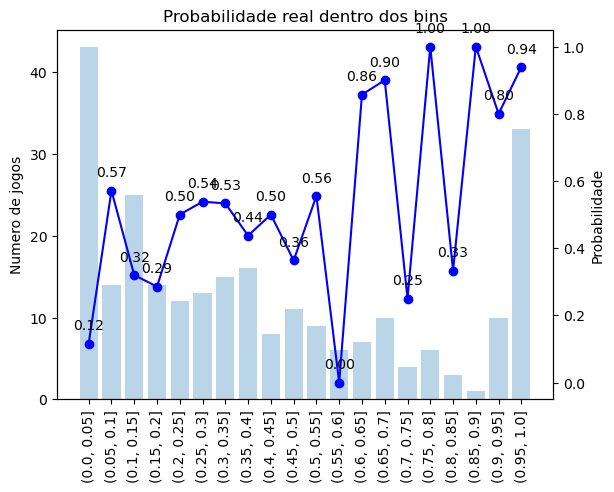

In [106]:
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'df'

# Define the bin intervals
bins = [i / 20 for i in range(21)]  # Bins of 5% from 0% to 100%

df = merge_teams.copy()
df['home_win'] = np.where(df['dif'] > 0, 1, 0)

# Assign each row to a bin based on the probabilities
df['Home_bin'] = pd.cut(df['Home'], bins)
#df['Draw_bin'] = pd.cut(df['Draw'], bins)
#df['Away_bin'] = pd.cut(df['Away'], bins)

# Calculate the average probability of the real results within each bin
df['Real_result'] = df['home_win'].astype(float)  # Assuming 'Real_result' is a string column
result_probs = df.groupby(['Home_bin'])['home_win'].mean().reset_index()

# Count the number of games in each bin
bin_counts = df.groupby(['Home_bin']).size().reset_index(name='Counts')

fig, ax1 = plt.subplots()

# Create the bar plot on the primary y-axis
ax1.bar(range(len(bin_counts)), bin_counts['Counts'], alpha=0.3)
ax1.set_ylabel('Numero de jogos')

# Create a secondary y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(range(len(result_probs)), result_probs['home_win'], marker='o', linestyle='-', color='blue')
ax2.set_ylabel('Probabilidade')

plt.xlabel('Bins')
plt.title('Probabilidade real dentro dos bins')
ax1.set_xticks(range(len(result_probs)))
ax1.set_xticklabels(result_probs['Home_bin'], rotation=90)

# Add data points as text annotations
for x, y in zip(range(len(result_probs)), result_probs['home_win']):
    ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

### Grid Search para o XGBoost

In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold



y = df_encoded['result']
x = df_encoded.drop(['result'],axis=1)
y = y.astype(int)
#df_encoded = df_encoded[df_encoded['Jornada'] > 5]

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=.2, shuffle=False, random_state=2023)

teams = X_test[['Data','dif','home','away']]

X_train = X_train.drop(['Data','home','away','dif'],axis=1)
X_test = X_test.drop(['Data','home','away','dif'],axis=1)

param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [500, 800, 1000, 1500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.9, 1.0]
}

xgb = XGBClassifier()

# Criar o objeto GridSearchCV com cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2023)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=3)
print('a')

# Realizar o grid search com os dados de treinamento
grid_search.fit(X_train, y_train)

# Imprimir os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros: ", grid_search.best_params_)
print("Melhor pontuação: ", grid_search.best_score_)

# Avaliar o modelo final nos dados de teste
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Acurácia nos dados de teste: ", accuracy)

a
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.8;, score=0.543 total time=   4.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.8;, score=0.561 total time=   4.4s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.8;, score=0.507 total time=   5.6s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=1.0;, score=0.514 total time=   4.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=1.0;, score=0.543 total time=   4.4s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=500, subsample=1.0;, score=0.525 total time=   4.5s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.005, max_depth=5, n_estimators=800, subsample=0.8;, score=0.543 total time=   7.

### Simulação de Monte Carlo 

In [202]:
df = pd.DataFrame(y_pred_proba, columns = ['Home','Draw','Away'])
df.head()
merge_teams = teams.copy().reset_index()
merge_teams['Home'] = df['Home']
merge_teams['Draw'] = df['Draw']
merge_teams['Away'] = df['Away']
merge_teams['result_pred'] = y_pred

##### Classificação real

In [189]:
from prettytable import PrettyTable

df_atual = dataset.copy()
df_atual = df_atual[df_atual['season'] == 2023]
df_atual = df_atual[df_atual['Jornada'] > 5]

classif_real = []

for team in df_atual['home'].unique():
    
    pontos = 0
    #df_atual
    pontos = df_atual[df_atual['home'] == team]['home_Points'].sum() 
    pontos += df_atual[df_atual['away'] == team]['away_Points'].sum()
    classif_real.append((team, pontos))

classif_real = sorted(classif_real, key=lambda x: x[1], reverse=True)

In [193]:
import random

df = merge_teams.copy()

# Função para simulação de Monte Carlo
def monte_carlo_simulation(df, num_simulations):
    results = []
    
    for u in range(num_simulations):
        team_points = {}
        
        for _, row in df.iterrows():
            home_team = row['home']
            away_team = row['away']
            home_prob = row['Home']
            draw_prob = row['Draw']
            away_prob = row['Away']
            
            outcome = random.choices([home_team, 'Draw', away_team], [home_prob, draw_prob, away_prob])[0]
            
            if outcome == home_team:
                team_points.setdefault(home_team, 0)
                team_points[home_team] += 3
            elif outcome == 'Draw':
                team_points.setdefault(home_team, 0)
                team_points[home_team] += 1
                team_points.setdefault(away_team, 0)
                team_points[away_team] += 1
            else:
                team_points.setdefault(away_team, 0)
                team_points[away_team] += 3
        
        results.append(team_points)
    
    return results

# Executando a simulação com 1000 iterações
num_simulations = 1000
simulation_results = monte_carlo_simulation(df, num_simulations)

# Calculando a classificação final com base nos resultados da simulação
final_standings = pd.DataFrame(simulation_results).T
final_standings['Total Points'] = final_standings.sum(axis=1) / num_simulations
final_standings = final_standings.sort_values(by='Total Points', ascending=False)
final_standings = final_standings['Total Points']

final_standings = pd.DataFrame(final_standings)

Classificação Final:
Benfica           78.178
Sp Lisbon         76.900
Sp Braga          71.610
Porto             71.249
Guimaraes         39.098
                   ...  
Portimonense      27.532
Chaves            26.683
Arouca            26.045
Santa Clara       25.525
Pacos Ferreira    24.953
Name: Total Points, Length: 18, dtype: float64


In [214]:
table = PrettyTable()
table.field_names = ["Equipa", "Pnts Previstos", "Pnts Reais", "Dif", "Pos Pred", "Pos Real"]

# Preenchimento da tabela com os dados
for i, (team, real_points) in enumerate(classif_real):
    predicted_points = final_standings.loc[final_standings.index == team, 'Total Points'].iloc[0]
    predicted_position = final_standings.index.get_loc(team) + 1
    diff_real_predicted = real_points - predicted_points
    table.add_row([team, f"{predicted_points:.1f}", real_points, f"{diff_real_predicted:.1f}", predicted_position, i + 1])

# Impressão da tabela
print(table)

+----------------+----------------+------------+------+----------+----------+
|     Equipa     | Pnts Previstos | Pnts Reais | Dif  | Pos Pred | Pos Real |
+----------------+----------------+------------+------+----------+----------+
|     Porto      |      71.2      |    73.0    | 1.8  |    4     |    1     |
|    Benfica     |      78.2      |    72.0    | -6.2 |    1     |    2     |
|   Sp Lisbon    |      76.9      |    67.0    | -9.9 |    2     |    3     |
|    Sp Braga    |      71.6      |    65.0    | -6.6 |    3     |    4     |
|   Guimaraes    |      39.1      |    47.0    | 7.9  |    5     |    5     |
|     Arouca     |      26.0      |    47.0    | 21.0 |    16    |    6     |
|   Famalicao    |      27.6      |    40.0    | 12.4 |    13    |    7     |
|     Chaves     |      26.7      |    38.0    | 11.3 |    15    |    8     |
|    Rio Ave     |      28.7      |    35.0    | 6.3  |    11    |    9     |
|     Vizela     |      35.1      |    35.0    | -0.1 |    6    

In [203]:
merge_teams.loc[merge_teams['dif'] > 0, 'result'] = '0'
merge_teams.loc[merge_teams['dif'] == 0, 'result'] = '1'
merge_teams.loc[merge_teams['dif'] < 0, 'result'] = '2'

In [209]:
merge_teams['profit'] = 0.0
merge_teams['result_pred'] = merge_teams['result_pred'].astype(int)
merge_teams['result'] = merge_teams['result'].astype(int)

# Aplicar as condições para preencher a coluna 'profit'
for index, row in merge_teams.iterrows():
    result_pred = row['result_pred']
    result = row['result']
    if result_pred != result:
        merge_teams.at[index, 'profit'] = -1
    elif result_pred == 0:
        merge_teams.at[index, 'profit'] = row['B365H'] - 1
    elif result_pred == 1:
        merge_teams.at[index, 'profit'] = row['B365D'] - 1
    elif result_pred == 2:
        merge_teams.at[index, 'profit'] = row['B365A'] - 1

In [211]:
merge_teams['profit'].sum()

-4.580000000000002

In [216]:
merge_teams['B365H'] = merge_teams['B365H'].astype(float)
merge_teams['B365A'] = merge_teams['B365A'].astype(float)
merge_teams['fav'] = np.where(merge_teams['B365H'] < merge_teams['B365A'], 0, 2)
merge_teams['fav'] = merge_teams['fav'].astype(int)
merge_teams['result'] = merge_teams['result'].astype(int)
merge_teams['profit_fav'] = 0.0
# Aplicar as condições para preencher a coluna 'profit'
for index, row in merge_teams.iterrows():
    fav = row['fav']
    result = row['result']
    if fav != result:
        merge_teams.at[index, 'profit_fav'] = -1
    elif fav == 0:
        merge_teams.at[index, 'profit_fav'] = row['B365H'] - 1
    elif fav == 2:
        merge_teams.at[index, 'profit_fav'] = row['B365A'] - 1

In [220]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
merge_teams.head()

,index,Data,dif,home,away,season,B365H,B365D,B365A,Home,Draw,Away,result_pred,result,profit,fav,profit_fav
0,1269,2022-09-09,1.0,Guimaraes,Santa Clara,2023,1.95,3.4,4.00,0.415060,0.546297,0.038642,1,0,-1.00,0,0.95
1,1270,2022-09-10,-1.0,Famalicao,Benfica,2023,7.00,4.5,1.40,0.006167,0.019516,0.974317,2,2,0.40,2,0.40
2,1271,2022-09-10,4.0,Sp Lisbon,Portimonense,2023,1.33,5.5,8.00,0.983205,0.008509,0.008285,0,0,0.33,0,0.33
3,1272,2022-09-10,3.0,Porto,Chaves,2023,1.14,7.0,19.00,0.916518,0.073419,0.010063,0,0,0.14,0,0.14
4,1273,2022-09-11,-1.0,Pacos Ferreira,Casa Pia,2023,2.80,3.1,2.62,0.386986,0.239062,0.373952,0,2,-1.00,2,1.62


In [225]:
merge_teams['profit_fav'].sum()

35.45